In [1]:
# This script extracts DNA-end sites associated with mtRNA (chrM) from iMARGI .pairs.gz files,
# merges nearby sites (±250 bp), and saves them as BED files for each sample.

import gzip
import pybedtools
import os

pairs_files = {
    "Day0": "/projectnb/perissilab/Xinyu/GPS2_CHIPseq/iMargi/output/final_SRR9900120.pairs.gz",
    "Day3": "/projectnb/perissilab/Xinyu/GPS2_CHIPseq/iMargi/output/final_SRR9900121.pairs.gz",
    "Day7": "/projectnb/perissilab/Xinyu/GPS2_CHIPseq/iMargi/output/final_SRR9900122.pairs.gz"
}

outdir = "/projectnb/perissilab/Xinyu/GPS2_CHIPseq/iMargi/analysis"
os.makedirs(outdir, exist_ok=True)

for name, pairs_file in pairs_files.items():
    dna_sites = []
    with gzip.open(pairs_file, "rt") as f:
        for line in f:
            if line.startswith("#"):
                continue
            cols = line.strip().split("\t")
            rna_chr = cols[1]
            dna_chr, dna_pos = cols[3], int(cols[4])

            # Filter for RNA-end that is mitochondrial (mtRNA)
            if rna_chr in ["chrM", "chrMT", "MT"]:
                dna_sites.append([dna_chr, dna_pos, dna_pos + 1])

    if len(dna_sites) == 0:
        print(f"{name}: No mtRNA-binding read pairs found!")
        continue

    # Merge nearby DNA-end sites within ±250 bp
    dna_bed = pybedtools.BedTool(dna_sites).sort().merge(d=500)
    
    outfile = os.path.join(outdir, f"mtRNA_DNA_sites_{name}.bed")
    dna_bed.saveas(outfile)
    print(f"{name}: Successfully generated {outfile}, number of regions: {len(dna_bed)}")


Day0: Successfully generated /projectnb/perissilab/Xinyu/GPS2_CHIPseq/iMargi/analysis/mtRNA_DNA_sites_Day0.bed, number of regions: 294752
Day3: Successfully generated /projectnb/perissilab/Xinyu/GPS2_CHIPseq/iMargi/analysis/mtRNA_DNA_sites_Day3.bed, number of regions: 380812
Day7: Successfully generated /projectnb/perissilab/Xinyu/GPS2_CHIPseq/iMargi/analysis/mtRNA_DNA_sites_Day7.bed, number of regions: 368771


In [2]:
#Overlap with HUVEC


=== Condition siCTL: total number of peaks = 36406 ===
siCTL - Day0: overlap count = 2390, percentage = 6.56%
siCTL - Day3: overlap count = 3004, percentage = 8.25%
siCTL - Day7: overlap count = 3613, percentage = 9.92%

=== Condition siGPS2: total number of peaks = 9302 ===
siGPS2 - Day0: overlap count = 513, percentage = 5.51%
siGPS2 - Day3: overlap count = 639, percentage = 6.87%
siGPS2 - Day7: overlap count = 757, percentage = 8.14%

=== Condition GPS2: total number of peaks = 33437 ===
GPS2 - Day0: overlap count = 3116, percentage = 9.32%
GPS2 - Day3: overlap count = 4174, percentage = 12.48%
GPS2 - Day7: overlap count = 4941, percentage = 14.78%

=== Overlap statistics table ===
  Condition Sample  Total peaks  Overlap count  Percentage (%)
0     siCTL   Day0        36406           2390        6.564852
1     siCTL   Day3        36406           3004        8.251387
2     siCTL   Day7        36406           3613        9.924188
3    siGPS2   Day0         9302            513       

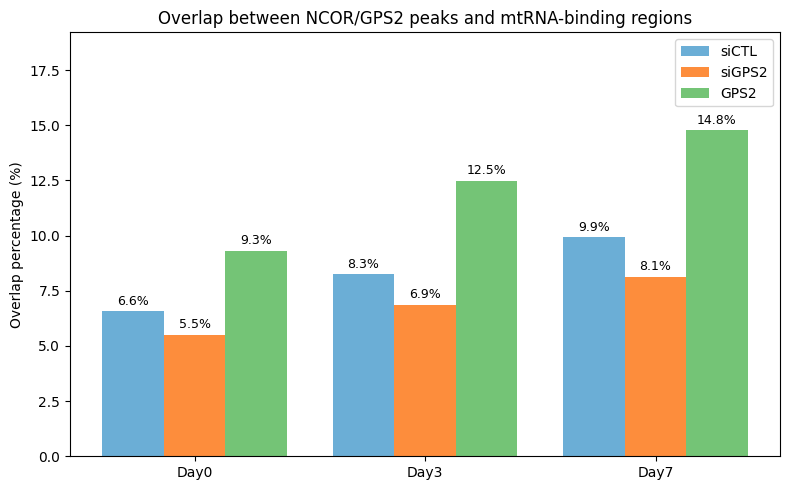

In [1]:
# This script calculates the overlap between NCOR/GPS2 TF peaks (siCTL vs siGPS2 vs GPS2)
# and mtRNA-binding regions (Day0/Day3/Day7) and visualizes the percentage overlap as a bar chart.

import pybedtools
import pandas as pd
import matplotlib.pyplot as plt

# === Input files ===
# mtRNA-binding region files
mtRNA_files = {
    "Day0": "/projectnb/perissilab/Xinyu/GPS2_CHIPseq/iMargi/analysis/mtRNA_DNA_sites_Day0.bed",
    "Day3": "/projectnb/perissilab/Xinyu/GPS2_CHIPseq/iMargi/analysis/mtRNA_DNA_sites_Day3.bed",
    "Day7": "/projectnb/perissilab/Xinyu/GPS2_CHIPseq/iMargi/analysis/mtRNA_DNA_sites_Day7.bed"
}

# TF peak files for three conditions
peak_files = {
    "siCTL": "/projectnb/perissilab/Xinyu/GPS2_CHIPseq/iMargi/T263/Peak_file/NCOR_siCTL_hg38.bed",
    "siGPS2": "/projectnb/perissilab/Xinyu/GPS2_CHIPseq/iMargi/T263/Peak_file/NCOR_siGPS2_hg38.bed",
    "GPS2": "/projectnb/perissilab/Xinyu/GPS2_CHIPseq/iMargi/T263/Peak_file/GPS2_minusTNFA_hg38.bed"
}

# === Calculate overlaps ===
results_all = []
for condition, peaks_path in peak_files.items():
    peaks_bed = pybedtools.BedTool(peaks_path)
    total_peaks = len(peaks_bed)
    print(f"\n=== Condition {condition}: total number of peaks = {total_peaks} ===")

    for name, mtRNA_file in mtRNA_files.items():
        mtRNA_bed = pybedtools.BedTool(mtRNA_file)
        overlap = peaks_bed.intersect(mtRNA_bed, u=True).count()
        percentage = overlap / total_peaks * 100 if total_peaks > 0 else 0
        results_all.append([condition, name, total_peaks, overlap, percentage])
        print(f"{condition} - {name}: overlap count = {overlap}, percentage = {percentage:.2f}%")

# === Save results into DataFrame ===
df = pd.DataFrame(results_all, columns=["Condition", "Sample", "Total peaks", "Overlap count", "Percentage (%)"])
print("\n=== Overlap statistics table ===")
print(df)

# Optional: save table to file
df.to_csv("NCOR_GPS2_mtRNA_overlap_stats.csv", index=False)

# === Visualization ===
plt.figure(figsize=(8, 5))

# Assign distinct colors for each condition
color_palette = {
    "siCTL": "#6baed6",
    "siGPS2": "#fd8d3c",
    "GPS2": "#74c476"
}

conditions = list(peak_files.keys())
bar_width = 0.8 / len(conditions)  # control spacing between bars

for i, day in enumerate(mtRNA_files.keys()):
    day_data = df[df["Sample"] == day]
    for j, condition in enumerate(conditions):
        percent = day_data.loc[day_data["Condition"] == condition, "Percentage (%)"].values[0]
        plt.bar(i + j * bar_width - 0.4 + bar_width / 2,
                percent,
                width=bar_width,
                color=color_palette[condition],
                label=condition if i == 0 else "")
        plt.text(i + j * bar_width - 0.4 + bar_width / 2,
                 percent + 0.3,
                 f"{percent:.1f}%",
                 ha="center",
                 fontsize=9)

plt.xticks(range(len(mtRNA_files)), mtRNA_files.keys())
plt.ylabel("Overlap percentage (%)")
plt.title("Overlap between NCOR/GPS2 peaks and mtRNA-binding regions")
plt.ylim(0, max(df["Percentage (%)"]) * 1.3)
plt.legend()
plt.tight_layout()
plt.show()


In [2]:
# This script performs Fisher's exact test to compare overlap proportions 
# of NCOR/GPS2 peaks with mtRNA-binding regions. It includes:
# 1) Intra-group comparisons (Day0 vs Day3, Day3 vs Day7 for each condition).
# 2) Inter-group comparisons (pairwise conditions at each time point).

from scipy.stats import fisher_exact
import pandas as pd
from itertools import combinations

# Ensure df exists from previous analysis (columns: Condition, Sample, Total peaks, Overlap count, Percentage (%))

# === 1. Intra-group comparisons ===
intra_results = []
print("\n=== Intra-group comparisons (within each condition across time points) ===")

for condition in df["Condition"].unique():
    subset = df[df["Condition"] == condition].set_index("Sample")

    for (day1, day2) in [("Day0", "Day3"), ("Day3", "Day7")]:
        if day1 in subset.index and day2 in subset.index:
            total_peaks = subset.loc[day1]["Total peaks"]  # total peaks same across days for same condition

            a = subset.loc[day1]["Overlap count"]
            b = total_peaks - a
            c = subset.loc[day2]["Overlap count"]
            d = total_peaks - c

            odds, p = fisher_exact([[a, b], [c, d]])
            print(f"{condition}: {day1} vs {day2} -> OR={odds:.2f}, P={p:.3e}")
            intra_results.append([condition, day1, day2, odds, p])

# Save intra-group comparisons
df_intra = pd.DataFrame(intra_results, columns=["Condition", "Day1", "Day2", "Odds ratio", "P-value"])
df_intra.to_csv("Fisher_intra_group_results.csv", index=False)


# === 2. Inter-group comparisons ===
inter_results = []
print("\n=== Inter-group comparisons (between conditions at each time point) ===")

for day in df["Sample"].unique():
    subset_day = df[df["Sample"] == day].set_index("Condition")

    # All pairwise combinations of conditions
    for cond1, cond2 in combinations(subset_day.index, 2):
        total1 = subset_day.loc[cond1]["Total peaks"]
        total2 = subset_day.loc[cond2]["Total peaks"]

        # Overlap vs non-overlap counts
        a = subset_day.loc[cond1]["Overlap count"]
        b = total1 - a
        c = subset_day.loc[cond2]["Overlap count"]
        d = total2 - c

        odds, p = fisher_exact([[a, b], [c, d]])
        print(f"{day}: {cond1} vs {cond2} -> OR={odds:.2f}, P={p:.3e}")
        inter_results.append([day, cond1, cond2, odds, p])

# Save inter-group comparisons
df_inter = pd.DataFrame(inter_results, columns=["Day", "Condition1", "Condition2", "Odds ratio", "P-value"])
df_inter.to_csv("Fisher_inter_group_results.csv", index=False)

print("\n=== Fisher's exact test results saved to CSVs ===")



=== Intra-group comparisons (within each condition across time points) ===
siCTL: Day0 vs Day3 -> OR=0.78, P=3.870e-18
siCTL: Day3 vs Day7 -> OR=0.82, P=4.365e-15
siGPS2: Day0 vs Day3 -> OR=0.79, P=1.414e-04
siGPS2: Day3 vs Day7 -> OR=0.83, P=1.124e-03
GPS2: Day0 vs Day3 -> OR=0.72, P=2.054e-39
GPS2: Day3 vs Day7 -> OR=0.82, P=5.745e-18

=== Inter-group comparisons (between conditions at each time point) ===
Day0: siCTL vs siGPS2 -> OR=1.20, P=1.831e-04
Day0: siCTL vs GPS2 -> OR=0.68, P=2.014e-41
Day0: siGPS2 vs GPS2 -> OR=0.57, P=4.942e-34
Day3: siCTL vs siGPS2 -> OR=1.22, P=8.901e-06
Day3: siCTL vs GPS2 -> OR=0.63, P=1.210e-75
Day3: siGPS2 vs GPS2 -> OR=0.52, P=6.249e-57
Day7: siCTL vs siGPS2 -> OR=1.24, P=1.172e-07
Day7: siCTL vs GPS2 -> OR=0.64, P=4.518e-85
Day7: siGPS2 vs GPS2 -> OR=0.51, P=2.231e-68

=== Fisher's exact test results saved to CSVs ===



Regardless of whether GPS2 is knocked down, the overlap percentage between mtRNA-binding regions and NCOR peaks increases significantly as the treatment duration is extended.
  
The overlap between mtRNA-binding regions and NCOR peaks increases with longer high glucose + TNFα treatment, regardless of GPS2 knockdown

GPS2 knockdown greatly reduces this overlap (OR ≈ 5), indicating GPS2 is essential for maintaining the interaction between these regions